本程序只能在Linux系统上直接运行。如果要在Windows或者Macos上运行，需要新建一个`.py`文件，复制代码，把主程序放在`if __name__ == "__main__"`下执行。

In [ ]:
from functions import load_pkls, lcs, lmap, flip, pmap
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# 显示中文
def get_font_name(index=0):
    if sys.platform == "win32":
        return "SimHei"
    index2 = 0 if sys.platform == "linux" else 1
    with os.popen('fc-list :lang=zh') as f:
        fonts = f.readlines()
        font_name = fonts[index].split(": ")[1].split(",")[index2]
        return font_name
plt.rcParams["font.sans-serif"] = get_font_name()
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.size"] = 16

dates = {
    lc: lmap(lambda x:os.path.basename(x).split(".")[0], sorted(glob(f"./data/{lc}/*.pkl"))) for lc in lcs
}

def get_m(lc="forest", n=3):
    # 闭合回路数量
    return int(len(dates[lc]) // n)

def normalize(a, abs=True):
    a %= (np.pi * 2)
    a[a > np.pi] -= np.pi * 2
    if abs:
        a = np.abs(a)
    return a

class Closure(object):
    def __init__(self, az=3, rg=7, number=0, n=3, lc="forest", closure_abs=True):
        # number表示组数，例如n=3时，第2组的索引是3*1:3*2
        self.az = az  # 方位向视数
        self.rg = rg  # 距离向视数
        self.lc = lc  # 地表覆盖类型
        self.dates = dates[lc][number*n: (number+1)*n]  # 影像序号
        self.n = len(self.dates)  # 闭合回路长度
        self.imgs = [load_pkls(lc, date) for date in self.dates]
        self.ints = [self.imgs[i] * np.conj(self.imgs[(i+1) % self.n]) for i in range(self.n)]  # 干涉对
        self.height = int(self.ints[0].shape[0] / self.az)  # 多视后的行数
        self.width = int(self.ints[0].shape[1] / self.rg)  # 多视后的列数
        self.az_slice = [slice(i, self.az*self.height,self.az) for i in range(self.az)]
        self.rg_slice = [slice(i, self.rg*self.width,self.rg) for i in range(self.rg)]
        self.closure_abs = closure_abs  # 闭合环残差是否取绝对值

    def windows_from(self, aijk):
        attr, i, j, k = aijk
        return getattr(self, attr)[i][self.az_slice[j], self.rg_slice[k]]
    
    def windows(self, attr="ints"):
        a = f"_{attr}_windows"
        if not hasattr(self, a):
            indexes = [(attr, i, j, k) for i in range(self.n) for j in range(self.az) for k in range(self.rg)]
            arr = np.reshape(lmap(self.windows_from, indexes), (self.n, self.az, self.rg, self.height, self.width))
            setattr(self, a, arr)
        return getattr(self, a)

    @property
    def closure(self):
        if not hasattr(self, "_closure"):
            multilook = self.windows().sum(axis=(1, 2))
            angle = np.angle(multilook).sum(axis=0)
            self._closure = normalize(angle, self.closure_abs)
        return self._closure

    @property
    def cov(self):
        if not hasattr(self, "_fir"):
            amp = np.abs(self.windows())
            pha = self.windows() / amp
            mean_amp = amp.mean((1, 2), keepdims=True)
            mean_pha = pha.mean((1, 2), keepdims=True)
            # E(a1a2)E(e^jΔθ)
            self._fir = np.squeeze(mean_amp * mean_pha)
            # Cov(a1a2, e^jΔθ)
            self._sec = np.mean((amp - mean_amp) * (pha - mean_pha), axis=(1, 2))
        return self._fir, self._sec

    @property
    def coherence(self) -> np.ndarray:
        waz = np.array([1 - np.abs(2 * (i - int(self.az // 2)) / (self.az + 1)) for i in range(self.az)])
        wrg = np.array([1 - np.abs(2 * (i - int(self.rg // 2)) / (self.rg + 1)) for i in range(self.rg)])
        wt = np.reshape([[i*j for i in wrg] for j in waz], (1, self.az, self.rg, 1, 1))
        p1 = np.abs(np.sum(self.windows() * wt, axis=(1,2)))
        p2 = np.sum(np.abs(self.windows("imgs")) ** 2 * wt, axis=(1,2)) ** 0.5
        p3 = np.concat((p2[1:], p2[:1]), axis=0)
        res = p1 / (p2 * p3) 
        return res

def flat(func, n=3):
    res = []
    for lc in lcs.keys():
        c_params = [{"number": i, "n": n, "lc": lc} for i in range(get_m(lc, n))]
        res.append(np.array(pmap(func, c_params)))
    return res

def hist(data, labels=None, xlabel=None, xrange=None, title=None, loc="center", ytitle=-0.35):
    data = [np.ravel(i) for i in data]
    weights = [np.ones(i.shape) /len(i) for i in data]
    plt.hist(data, weights=weights, range=xrange,bins=10, label=labels)
    plt.xlabel(xlabel, loc=loc)
    plt.ylabel("频率")
    plt.legend()
    plt.title(title, y=ytitle)

def cum_plot(data, labels=None, xlabel=None, xrange=None, title=None, loc="center", ytitle=-0.35):
    if labels is None:
        labels = [None for _ in data]
    for i, j in zip(data, labels):
        x = np.sort(np.ravel(i))
        y = np.cumsum(np.ones(x.shape)) / len(x)
        plt.plot(x, y, label=j)
    if xrange is not None:
        plt.xlim(xrange)
    plt.xlabel(xlabel, loc=loc)
    plt.ylabel("累积频率")
    plt.legend()
    plt.title(title, y=ytitle)

# 空间平均处理的影响

## 闭合环残差与辐角项残差的比较

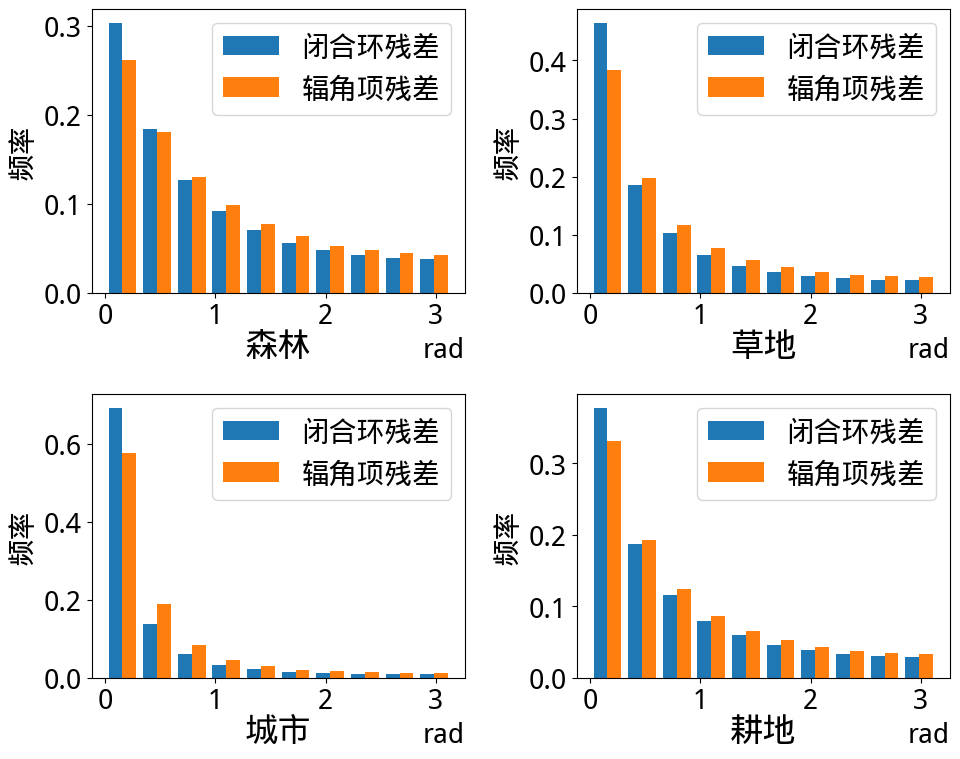

In [28]:
def compare_closure_first(kwargs):
    c = Closure(**kwargs)
    first_residual = normalize(np.angle(c.cov[0]).sum(axis=0))
    return c.closure.ravel(), first_residual.ravel()

def display_closure_first(data):
    plt.figure(figsize=(10, 8))
    for index, v in enumerate(data):
        plt.subplot(2,2,index + 1)
        hist((v[:, 0], v[:, 1]), labels=['闭合环残差', '辐角项残差'], xlabel="rad",title=list(lcs.values())[index], loc="right", ytitle=-0.25)
        # cum_plot((v[:, 0], v[:, 1]), labels=['闭合环残差', '辐角项残差'], xlabel="rad",title=list(lcs.values())[index], loc="right", ytitle=-0.25)
    plt.tight_layout()
    plt.show()

data = flat(compare_closure_first)
display_closure_first(data)

## 辐角项和协方差项的振幅、相位比较

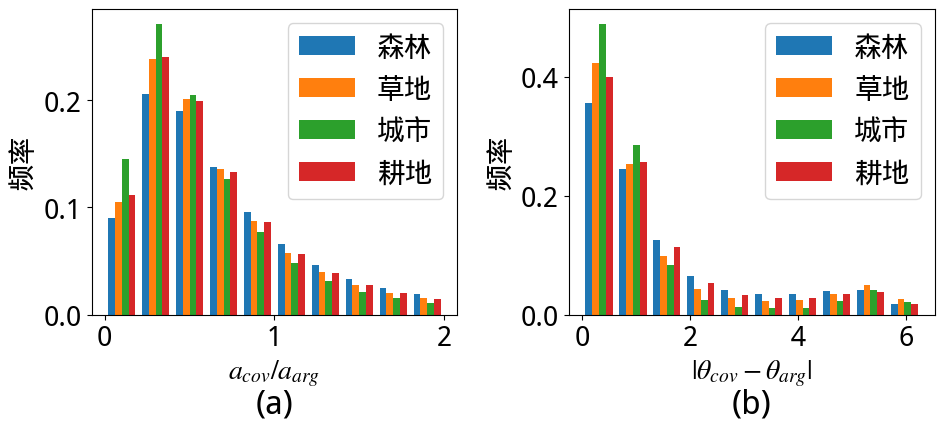

In [27]:
def compare_first_second(kwargs):
    c = Closure(**kwargs)
    fir, sec = c.cov
    amp_ratio = np.abs(sec) / np.abs(fir)
    pha_diff = np.abs(np.angle(sec) - np.angle(fir))
    shape = (fir.shape[0], -1)
    return amp_ratio.reshape(shape), pha_diff.reshape(shape)

def display_first_second(data):
    plt.figure(figsize=(10, 5))
    plt.rcParams["font.size"] = 20
    plt.subplot(1,2,1)
    hist([i[:, 0] for i in data], labels=lcs.values(), xlabel=r"$a_{cov}/a_{arg}$", xrange=[0,2], title="(a)")
    # cum_plot([i[:, 0] for i in data], labels=lcs.values(), xlabel=r"$a_{cov}/a_{arg}$", xrange=[0,2], title="(a)")
    plt.subplot(1,2,2)
    hist([i[:, 1] for i in data], labels=lcs.values(), xlabel=r"$|\theta_{cov}-\theta_{arg}|$", title="(b)")
    # cum_plot([i[:, 1] for i in data], labels=lcs.values(), xlabel=r"$|\theta_{cov}-\theta_{arg}|$", title="(b)")
    plt.tight_layout()
    plt.show()

data = flat(compare_first_second)
display_first_second(data)

# 空间平均窗口大小的影响
## 取平均

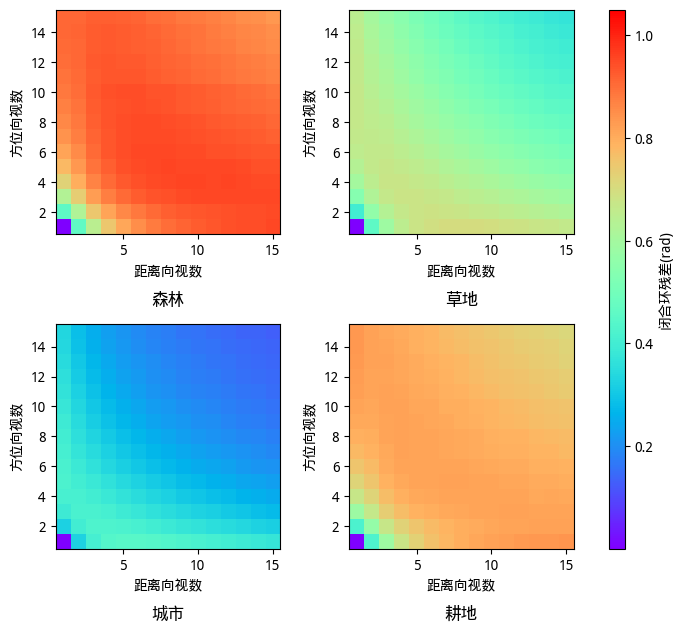

In [16]:
def get_closure(kwargs):
    return Closure(**kwargs).closure

def closure_mean(kwargs):
    return np.mean(get_closure(kwargs))

def compare_closure_looks(n_looks=15, closure_abs=True):
    shape = (len(lcs), n_looks, n_looks, get_m())
    cs = [{
        "lc": list(lcs.keys())[i], 
        "az": j+1, 
        "rg": k+1, 
        "number": h, 
        "closure_abs":closure_abs
        } for i in range(shape[0]) for j in range(shape[1]) for k in range(shape[2]) for h in range(shape[3])]
    return np.reshape(pmap(closure_mean, cs), shape).mean(axis=-1)

def imshow_closure_looks(data, ax, title, vmax=None):
    img = ax.imshow(data, origin="lower", extent=(0.5, data.shape[1]+0.5,0.5, data.shape[0]+0.5,), cmap="rainbow", vmax=vmax)
    ax.set_xlabel("距离向视数")
    ax.set_ylabel("方位向视数")
    ax.set_title(title,y=-0.35)
    return img

def display_closure_looks(data):
    plt.rcParams['font.size'] = 10
    fig, axes = plt.subplots(2, 2, figsize=(8, 7))
    img = None
    for i, j, k in zip(data, axes.ravel(), lcs.values()):
        img = imshow_closure_looks(i, j, k, vmax=1.05)
    fig.colorbar(img, cax=fig.add_axes([0.88,0.11,0.02,0.77])).set_label("闭合环残差(rad)")
    fig.subplots_adjust(hspace=0.4, wspace=-0.1)
    plt.show()

data = compare_closure_looks()
display_closure_looks(data)

## 不取绝对值的闭合环残差

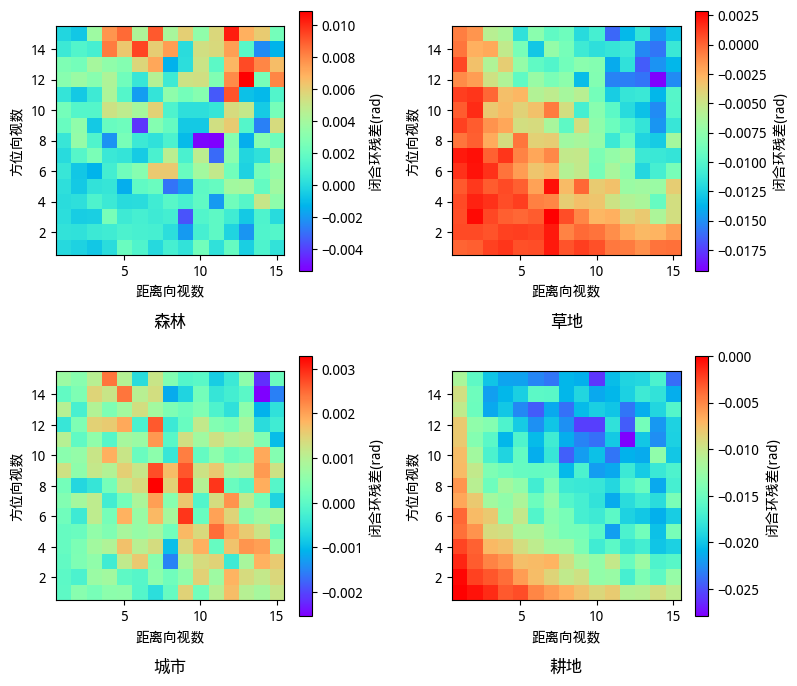

In [17]:
def display_closure_looks_without_abs(data):
    plt.rcParams['font.size'] = 10
    fig, axes = plt.subplots(2, 2, figsize=(8, 7))
    img = None
    for i, j, k in zip(data, axes.ravel(), lcs.values()):
        img = imshow_closure_looks(i, j, k)
        fig.colorbar(img).set_label("闭合环残差(rad)")
    plt.tight_layout()
    plt.show()

data = compare_closure_looks(closure_abs=False)

# from pickle import dump, load
# with open("closure_without_abs.pkl", "wb") as f:
#     dump(data, f)
# with open("closure_without_abs.pkl", "rb") as f:
#     data = load(f)

display_closure_looks_without_abs(data)

## 森林地区的闭合环残差随视数变化细节

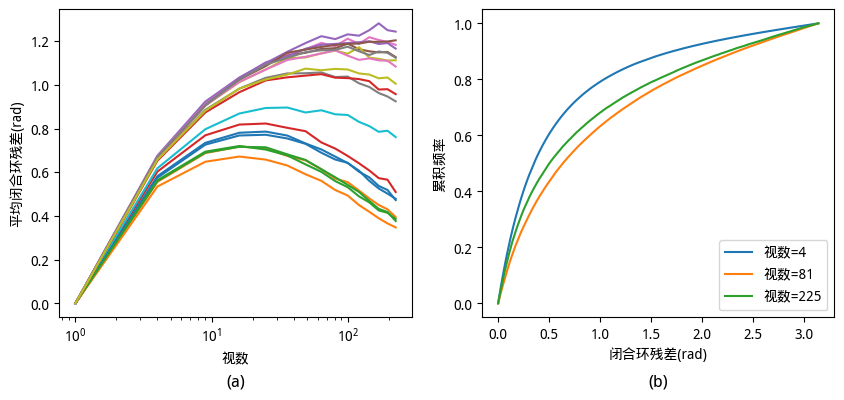

In [30]:
def looks_details(n_looks=15, lc="forest"):
    m = get_m(lc)
    cs = [{
        "az": look+1,
        "rg": look+1, 
        "number": number, 
        "lc": lc
        } for number in range(m) for look in range(n_looks) ]
    res = pmap(get_closure, cs)
    means = np.empty((m, n_looks))
    hists = [[] for _ in range(n_looks)]
    for i in range(m):
        for j in range(n_looks):
            v = res[i * n_looks + j]
            means[i, j] = v.mean()
            hists[j].append(v)
    hists = [np.concat(i, axis=0) for i in hists]
    return means, hists

def display_looks_details(data):
    means, hists = data
    plt.rcParams['font.size'] = 10
    plt.figure(figsize=(10, 4))
    plt.subplot(1,2,1)
    for i in means:
        plt.plot((np.arange(len(i)) + 1)**2, i)
    plt.xscale("log")
    plt.xlabel("视数")
    plt.ylabel("平均闭合环残差(rad)")
    plt.title("(a)", y=-0.25)
    plt.subplot(1,2,2)
    labels = [2, 9, 15]
    # hist([hists[i-1] for i in labels], labels=[f"视数={i**2}" for i in labels], xlabel="闭合环残差(rad)", title="(b)", ytitle=-0.25)
    cum_plot([hists[i-1] for i in labels], labels=[f"视数={i**2}" for i in labels], xlabel="闭合环残差(rad)", title="(b)", ytitle=-0.25)
    plt.show()

data = looks_details()
display_looks_details(data)

# 时间平均处理规模的影响

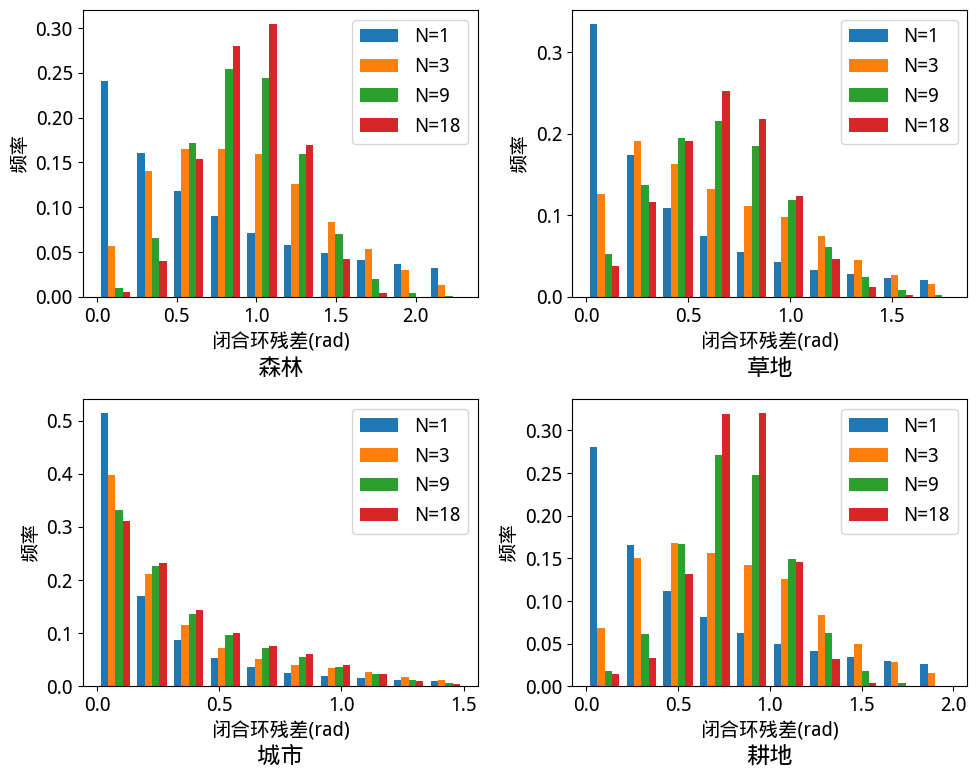

In [32]:
def compare_closure_time_nums(Ns=(1,3,9,18), n=3, m=18):
    res = {}
    for lc in lcs.keys():
        c_params = [{"number": i, "n": n, "lc": lc} for i in range(m)]
        data = np.array(pmap(get_closure, c_params))
        res[lc] = [data.reshape((N, int(m/N)) + data.shape[1:]).mean(axis=0).ravel() for N in Ns]
    return res, Ns

def display_closure_time_nums(params):
    data, Ns = params
    plt.figure(figsize=(10, 8))
    plt.rcParams['font.size'] = 14
    for i, lc in enumerate(lcs.keys()):
        xrange = {
            "forest": (0, 2.3),
            "grassland": (0, 1.8),
            "impervious": (0, 1.5),
            "cropland": (0, 2.0)
        }
        plt.subplot(2,2,i+1)
        hist(data[lc], labels=[f"N={i}" for i in Ns], xlabel="闭合环残差(rad)", title=lcs[lc], xrange=xrange[lc], ytitle=-0.3)
        # cum_plot(data[lc], labels=[f"N={i}" for i in Ns], xlabel="闭合环残差(rad)", title=lcs[lc], xrange=xrange[lc], ytitle=-0.3)
    plt.tight_layout()
    plt.show()

params = compare_closure_time_nums()
display_closure_time_nums(params)

# 闭合回路长度的影响

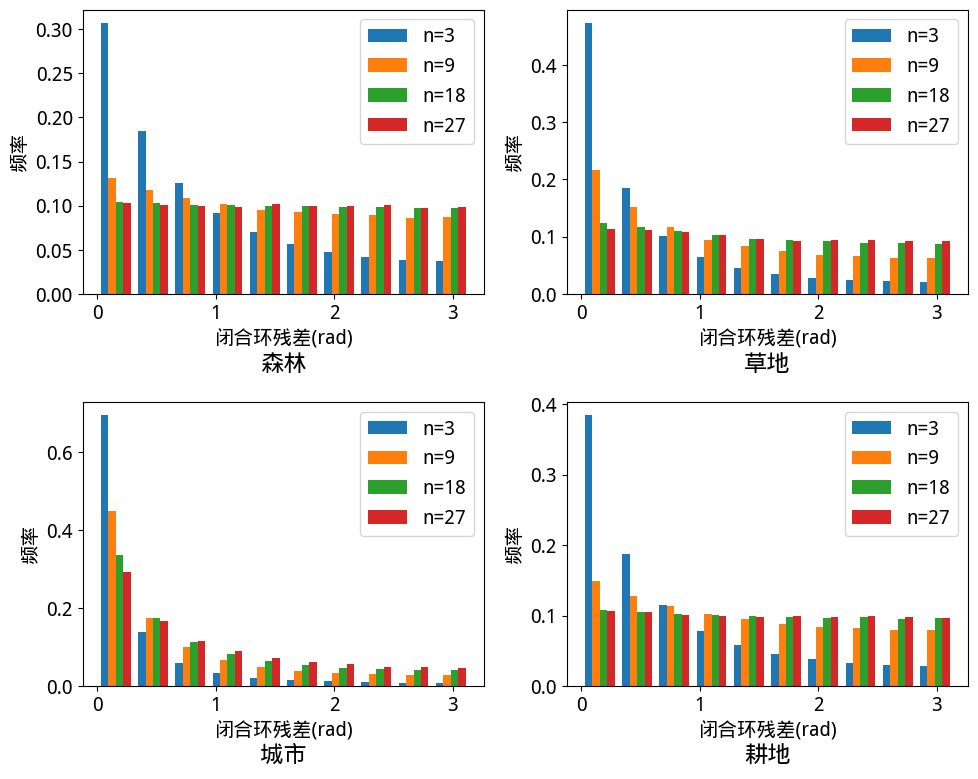

In [34]:
def compare_closure_lens(ns=(3,9,18,27), amount=54, mean=False):
    res = {lc: [] for lc in lcs.keys()}
    for lc in lcs.keys():
        c_params = [{"number": i, "n": n, "lc": lc} for n in ns for i in range(int(amount/n))]
        data = pmap(get_closure, c_params)
        start = 0
        for n in ns:
            end = start + int(amount/n)
            part = data[start: end]
            if mean:
                part = np.mean(part, axis=0)
            else:
                part = np.ravel(part)
            res[lc].append(part)
            start = end
    return res, ns

def display_closure_lens(params):
    data, ns = params
    plt.figure(figsize=(10, 8))
    plt.rcParams['font.size'] = 14
    for i, lc in enumerate(lcs.keys()):
        plt.subplot(2,2,i+1)
        hist(data[lc], labels=[f"n={i}" for i in ns], xlabel="闭合环残差(rad)", title=lcs[lc], ytitle=-0.3)
        # cum_plot(data[lc], labels=[f"n={i}" for i in ns], xlabel="闭合环残差(rad)", title=lcs[lc], ytitle=-0.3)
    plt.tight_layout()
    plt.show()

params = compare_closure_lens()
display_closure_lens(params)


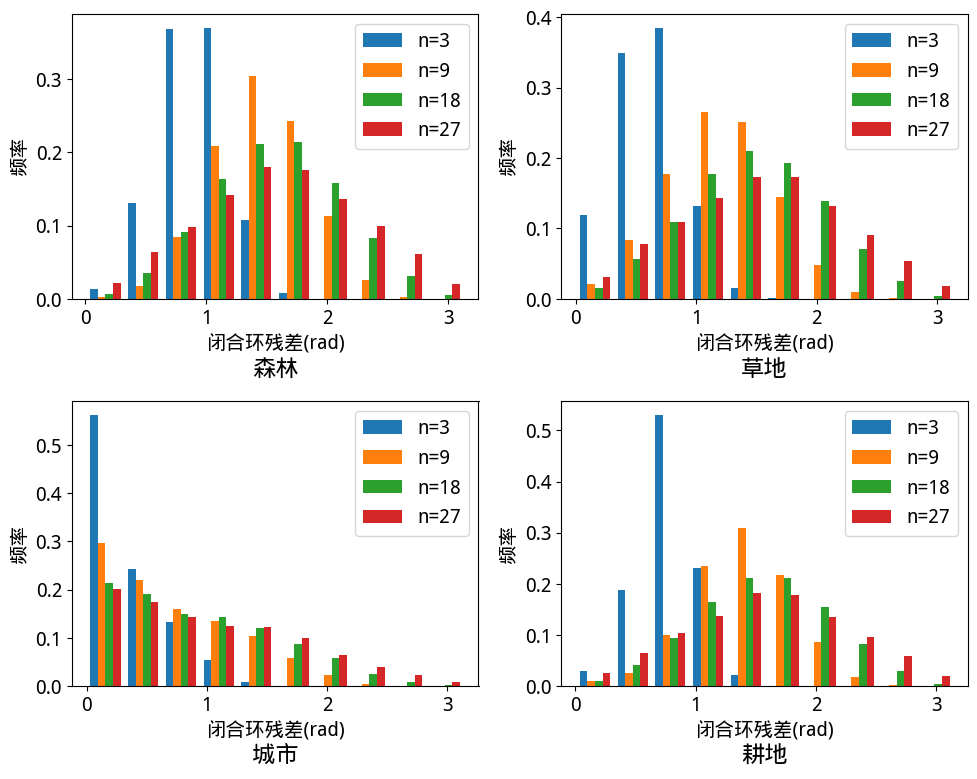

In [8]:
params = compare_closure_lens(mean=True)
display_closure_lens(params)

# 时间基线长度的影响

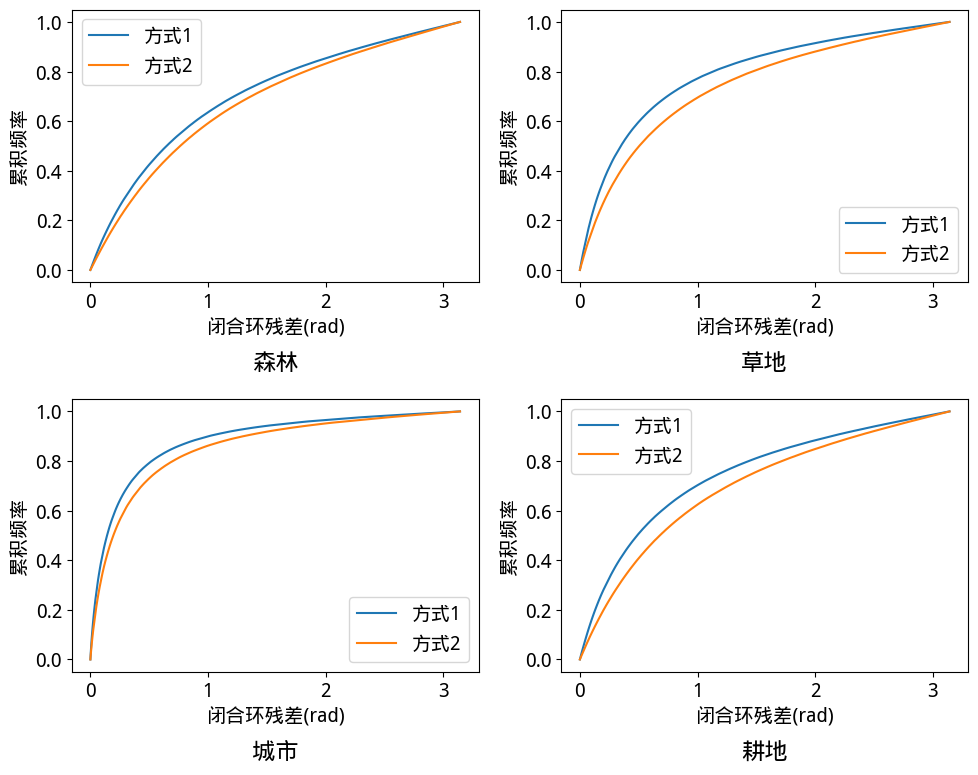

In [36]:
from copy import deepcopy

def get_closure_group(kwargs):
    g = kwargs["g"]
    del kwargs["g"]
    cs = []
    for i in range(kwargs["n"]):
        kwargs["number"] = i + g * kwargs["n"]
        cs.append(Closure(**kwargs))
    cs2 = deepcopy(cs)
    for i in range(kwargs["n"]):
        for j in range(kwargs["n"]):
            cs2[j].imgs[i] = cs[i].imgs[j]
    for c in cs2:
        c.ints = [c.imgs[i] * np.conj(c.imgs[(i+1) % c.n]) for i in range(c.n)]
    return np.array([i.closure for i in cs]), np.array([i.closure for i in cs2])

def compare_closure_time_lens(lc, n=3):
    ng = int(get_m(lc) // n)
    css = [{"lc": lc, "n": n, "g": g} for g in range(ng)]
    data = np.reshape(pmap(get_closure_group, css), (ng, 2, -1))
    return data[:, 0].ravel(), data[:, 1].ravel()

def display_closure_time_lens(data):
    plt.figure(figsize=(10, 8))
    for i, lc in enumerate(lcs.keys()):
        plt.subplot(2,2,i+1)
        # hist(data[lc], labels=[f"方式{i+1}" for i in range(2)],xlabel="闭合环残差(rad)",title=lcs[lc])
        cum_plot(data[lc], labels=[f"方式{i+1}" for i in range(2)],xlabel="闭合环残差(rad)",title=lcs[lc])
    plt.tight_layout()
    plt.show()

data = {lc: compare_closure_time_lens(lc) for lc in lcs.keys()}
display_closure_time_lens(data)

# 与相干性的关系

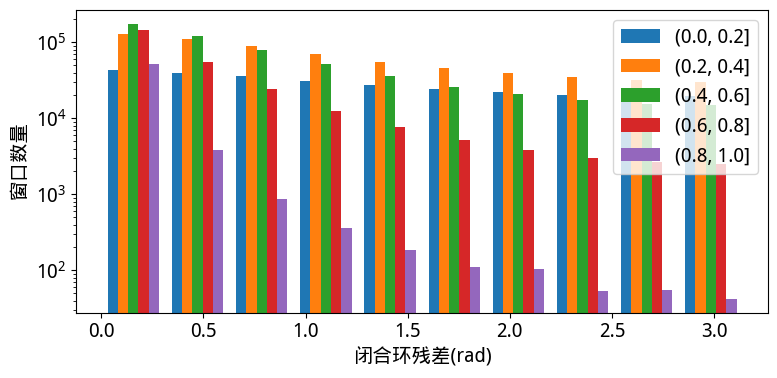

In [37]:
def compare_closure_coherence(number):
    c = Closure(number=number)
    clo = np.expand_dims(c.closure, axis=0).repeat(c.n, axis=0)
    return clo.ravel(), c.coherence.ravel()

def display_closure_coherence(data):
    clo, coh = data
    intervals = np.arange(0, 1.01, 0.2)
    p = [np.logical_and(coh > intervals[i], coh <= intervals[i+1]) for i in range(len(intervals)-1)]
    plt.figure(figsize=(8, 4))
    plt.hist([clo[i] for i in p], label=[f"({i:.1f}, {j:.1f}]" for i, j in zip(intervals[:-1], intervals[1:])])
    plt.yscale("log")
    plt.xlabel("闭合环残差(rad)")
    plt.ylabel("窗口数量")
    plt.legend()
    plt.tight_layout()
    plt.show()

def p_ravel(data):
    data = np.swapaxes(data, 0, 1)
    return np.reshape(data, (data.shape[0], -1))

lc = "forest"
data = pmap(compare_closure_coherence, [i for i in range(get_m(lc))])
display_closure_coherence(p_ravel(data))

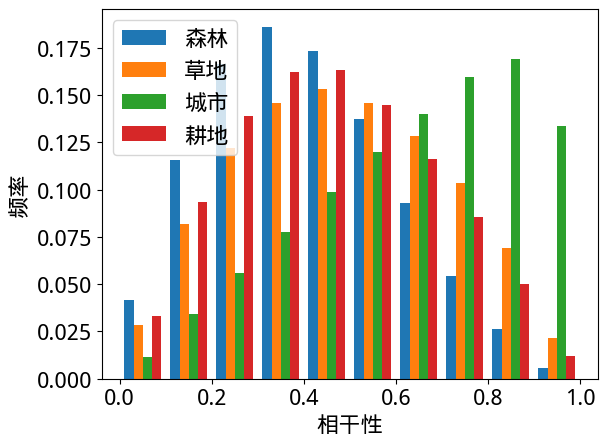

In [47]:
def get_coherence(kwargs):
    return Closure(**kwargs).coherence.ravel()

def compare_coherence():
    data = []
    for lc in lcs.keys():
        data.append(pmap(get_coherence, [{"number": i, "lc": lc} for i in range(get_m(lc))]))
    hist(data, lcs.values(), "相干性")

compare_coherence()

# 后面都是最后没有用上的

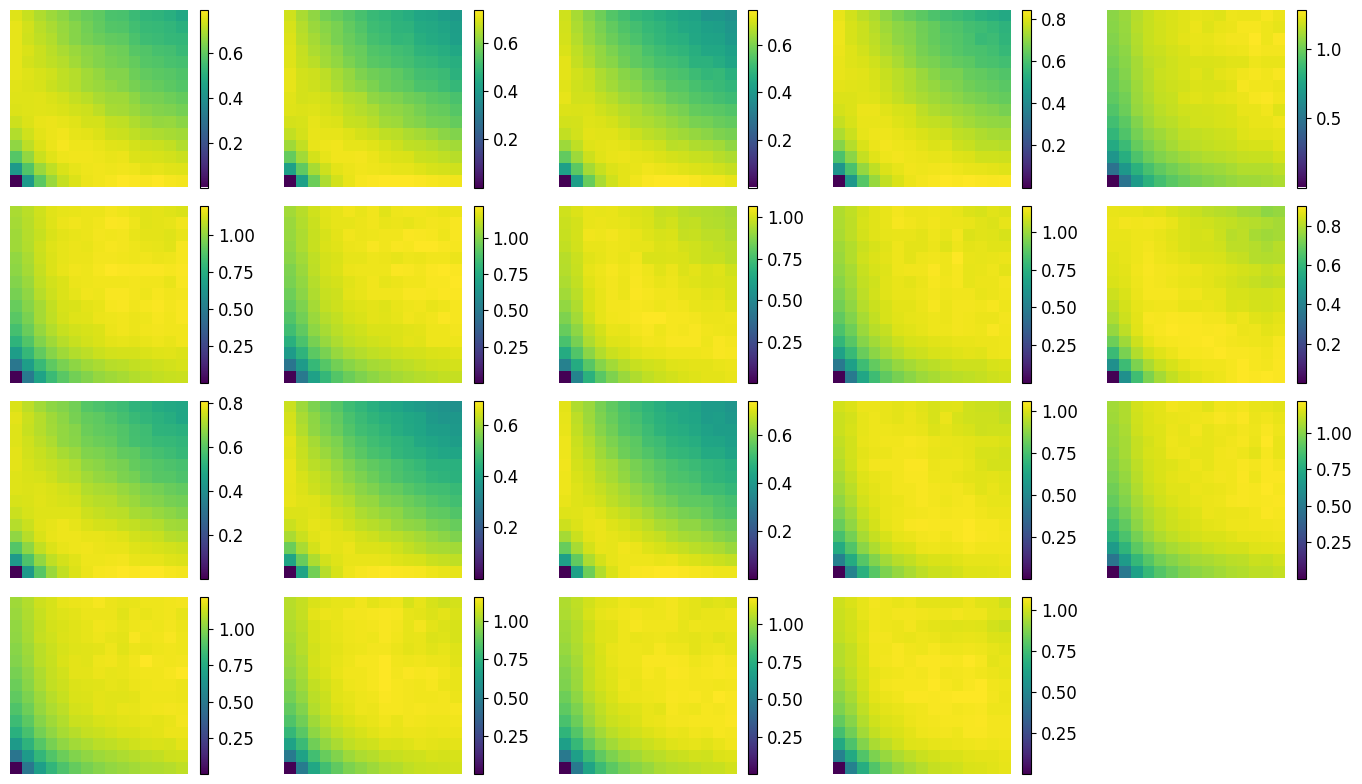

In [101]:
n_looks = 15
lc = "forest"
m = get_m(lc)
p = Pool()
states = np.empty((m, n_looks, n_looks), dtype=ApplyResult)
for number in range(m):
    for az in range(n_looks):
        for rg in range(n_looks):
            states[number, az, rg] = p.apply_async(compare_looks, args=(az+1, rg+1, number, lc))
p.close()
p.join()
res = np.empty(states.shape)
for i in range(res.shape[0]):
    for j in range(res.shape[1]):
        for k in range(res.shape[2]):
            res[i, j, k] = states[i, j, k].get()
plt.figure(figsize=(14, 8))
for i, data in enumerate(res):
    plt.subplot(4,5,i+1)
    plt.imshow(data, origin="lower", extent=(0.5, data.shape[1]+0.5,0.5, data.shape[0]+0.5,))
    plt.axis("off")
    plt.colorbar()
plt.tight_layout()
plt.show()

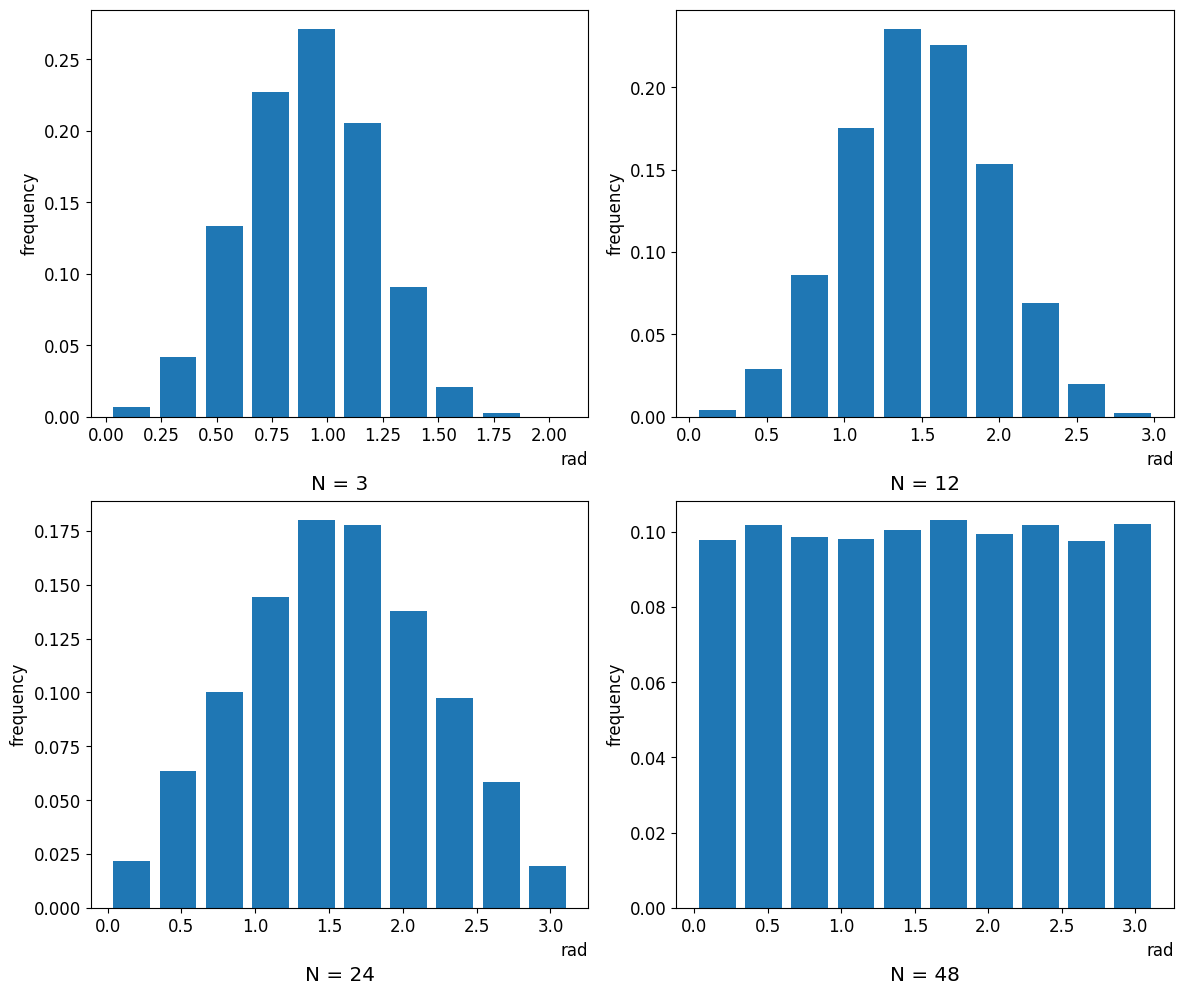

In [137]:
lc = "forest"
plt.figure(figsize=(12, 10))
mn = 48
for i, j in enumerate((3,12,24,48)):
    plt.subplot(2,2,i+1)
    data = np.mean(lmap(lambda c: c.closure, [Closure(number=k,n=j, lc=lc) for k in range(int(mn // j))]), axis=0).ravel()
    weights = np.ones(data.shape) /len(data)
    plt.hist(data, weights=weights, rwidth=0.8)
    plt.xlabel("rad", loc='right')
    plt.ylabel("frequency")
    plt.title(f"N = {j}", y=-0.2)
plt.tight_layout()
plt.show()

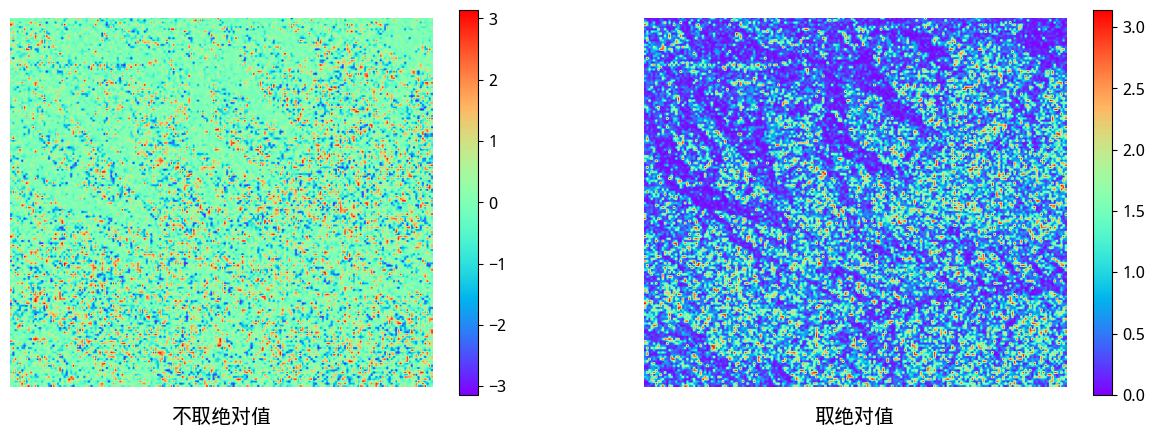

In [67]:
c = Closure(closure_abs=False)
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.imshow(c.closure, origin="lower", cmap="rainbow")
plt.colorbar()
plt.axis("off")
plt.title("不取绝对值", y=-0.12)
plt.subplot(1,2,2)
plt.imshow(np.abs(c.closure), origin="lower", cmap="rainbow")
plt.colorbar()
plt.axis("off")
plt.title("取绝对值", y=-0.12)
plt.show()

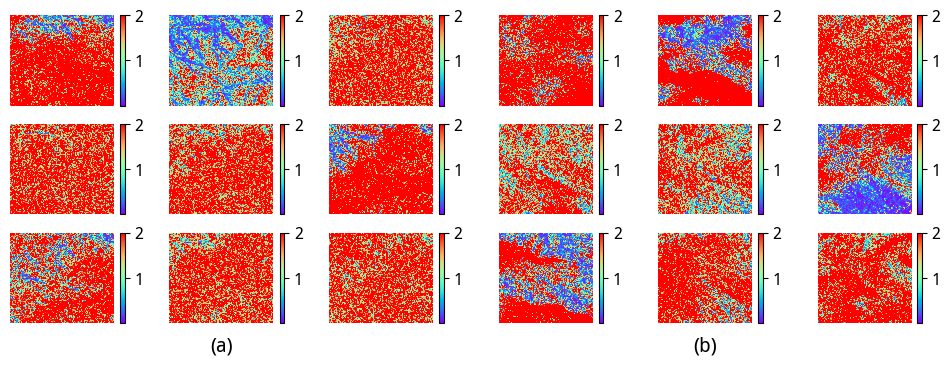

In [ ]:
def display_closure(data, left=True):
    for i in range(3):
        for j in range(3):
            pos = i*6+j+1 if left else i*6+j+4
            plt.subplot(3,6,pos)
            plt.imshow(data[(i*3+j)*2], origin="lower", cmap="rainbow", vmax=2)
            plt.axis("off")
            plt.colorbar()
            if i == 2 and j == 1:
                plt.title("(a)" if left else "(b)", y=-0.4)

lc, n = "forest", 3
cs = [Closure(number=i, n=n, lc=lc) for i in range(get_m(lc,n))]
forest = pmap(partial(flip, getattr, "closure"), cs)
lc = "grassland"
cs = [Closure(number=i, n=n, lc=lc) for i in range(get_m(lc,n))]
grassland = pmap(partial(flip, getattr, "closure"), cs)

plt.figure(figsize=(12,4))
plt.rcParams.update({"font.size": 12})
display_closure(forest)
display_closure(grassland, False)
plt.show()

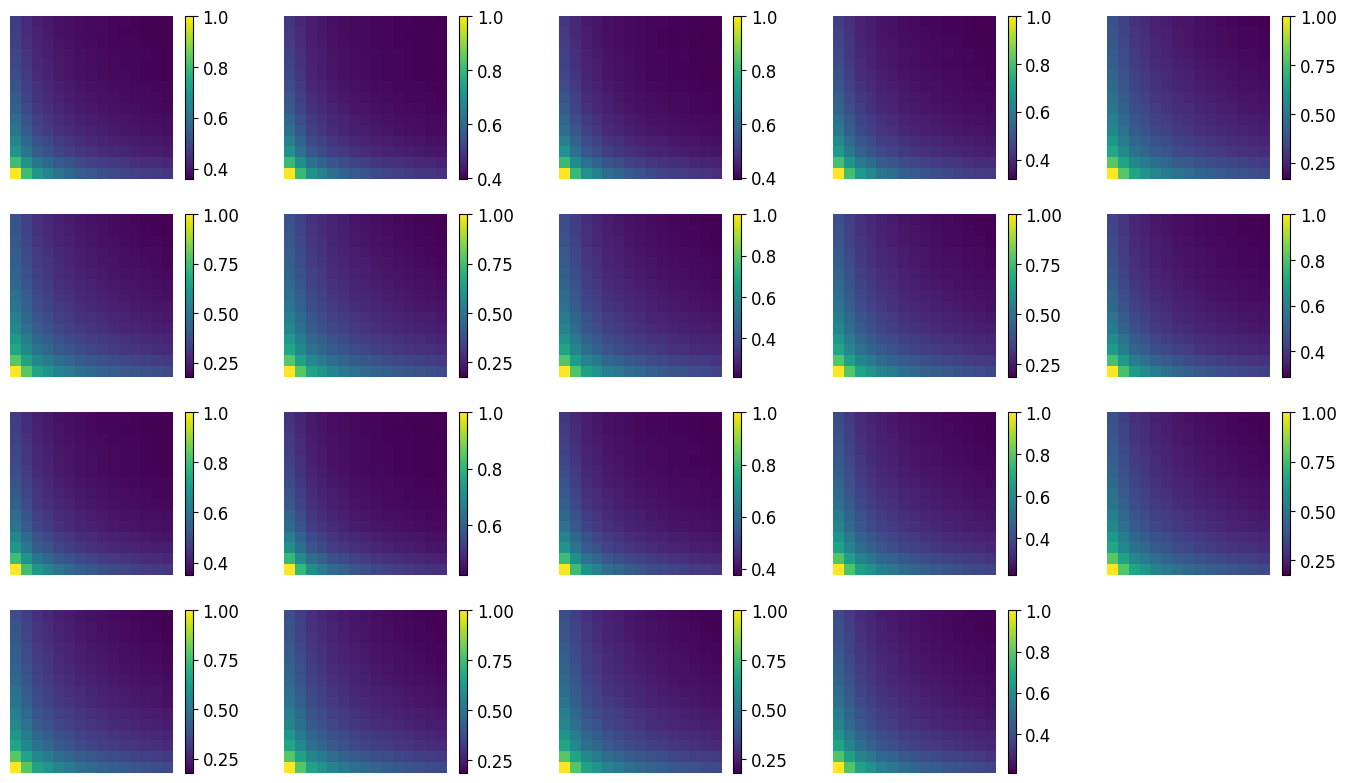

In [ ]:
def compare_looks_coherence(az, rg, number, lc):
    c = Closure(az=az, rg=rg, number=number, lc=lc)
    return c.coherence.mean()

n_looks = 15
lc = "forest"
m = get_m(lc)
p = Pool()
states = np.empty((m, n_looks, n_looks), dtype=ApplyResult)
for number in range(m):
    for az in range(n_looks):
        for rg in range(n_looks):
            states[number, az, rg] = p.apply_async(compare_looks_coherence, args=(az+1, rg+1, number, lc))
p.close()
p.join()
res = np.empty(states.shape)
for i in range(res.shape[0]):
    for j in range(res.shape[1]):
        for k in range(res.shape[2]):
            res[i, j, k] = states[i, j, k].get()
plt.figure(figsize=(14, 8))
for i, data in enumerate(res):
    plt.subplot(4,5,i+1)
    plt.imshow(data, origin="lower", extent=(0.5, data.shape[1]+0.5,0.5, data.shape[0]+0.5,))
    plt.axis("off")
    plt.colorbar()
plt.tight_layout()
plt.show()

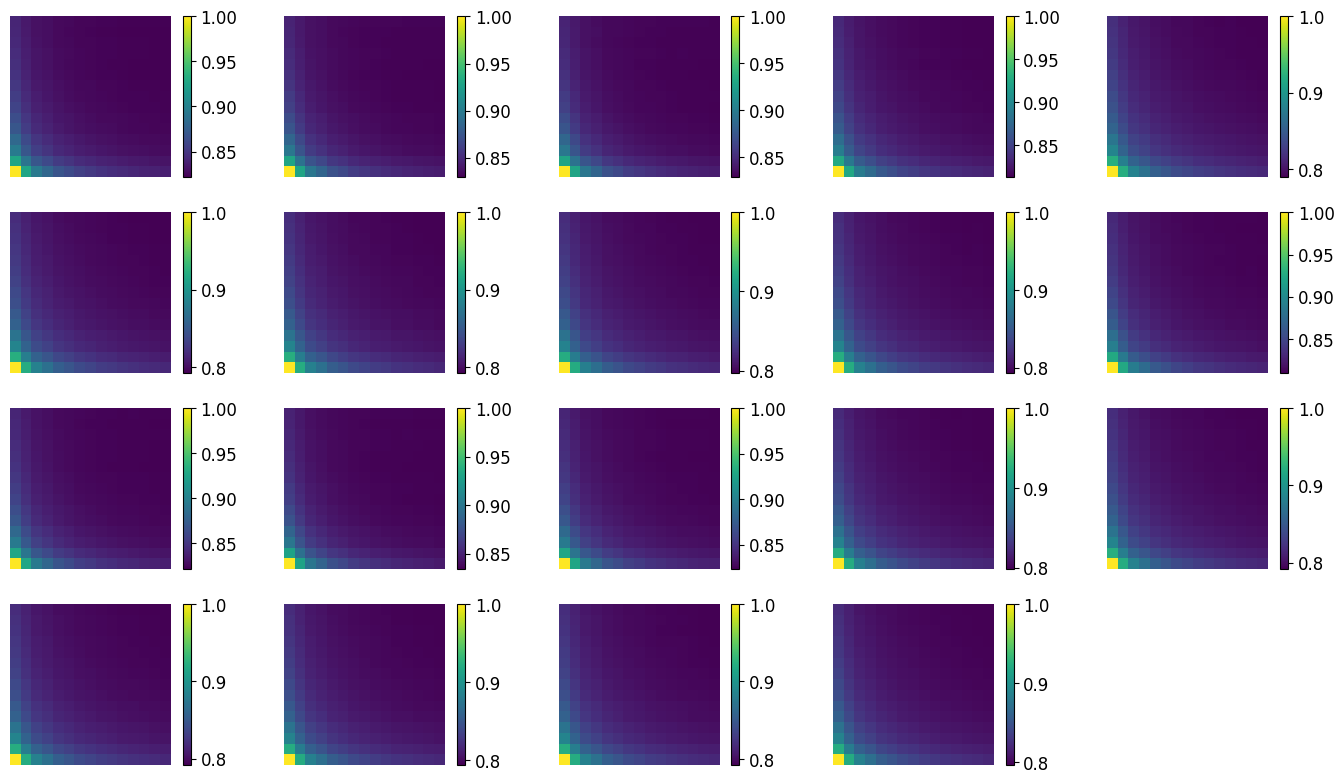

In [138]:
# 振幅相关性与视数的关系

class Closure_with_cor(Closure):
    @property
    def correlation(self) -> np.ndarray:
        res = np.zeros((self.n, self.height, self.width))
        for count in range(self.n):
            ref = self.imgs[count]
            sec = self.imgs[(count + 1) % self.n]
            waz = np.array([1 - np.abs(2 * (i - int(self.az // 2)) / (self.az + 1)) for i in range(self.az)])
            wrg = np.array([1 - np.abs(2 * (i - int(self.rg // 2)) / (self.rg + 1)) for i in range(self.rg)])
            multiply = np.abs(ref) * np.abs(sec)
            ref2 = np.abs(ref) ** 2
            sec2 = np.abs(sec) ** 2
            p1 = np.zeros(res.shape[1:], np.complex64)
            p2 = np.zeros(res.shape[1:], np.float32)
            p3 = np.zeros(res.shape[1:], np.float32)
            for i, az_slice in enumerate(self.az_slice):
                for j, rg_slice in enumerate(self.rg_slice):
                    wt = waz[i] * wrg[j]
                    p1 += multiply[az_slice, rg_slice] * wt
                    p2 += ref2[az_slice, rg_slice] * wt
                    p3 += sec2[az_slice, rg_slice] * wt
            res[count] = (np.abs(p1)/ (p2 * p3) ** 0.5)
        return res

def compare_looks_correlation(az, rg, number, lc):
    c = Closure_with_cor(az=az, rg=rg, number=number, lc=lc)
    return c.correlation.mean()

n_looks = 15
lc = "forest"
m = get_m(lc)
p = Pool()
states = np.empty((m, n_looks, n_looks), dtype=ApplyResult)
for number in range(m):
    for az in range(n_looks):
        for rg in range(n_looks):
            states[number, az, rg] = p.apply_async(compare_looks_correlation, args=(az+1, rg+1, number, lc))
p.close()
p.join()
res = np.empty(states.shape)
for i in range(res.shape[0]):
    for j in range(res.shape[1]):
        for k in range(res.shape[2]):
            res[i, j, k] = states[i, j, k].get()
plt.figure(figsize=(14, 8))
for i, data in enumerate(res):
    plt.subplot(4,5,i+1)
    plt.imshow(data, origin="lower", extent=(0.5, data.shape[1]+0.5,0.5, data.shape[0]+0.5,))
    plt.axis("off")
    plt.colorbar()
plt.tight_layout()
plt.show()

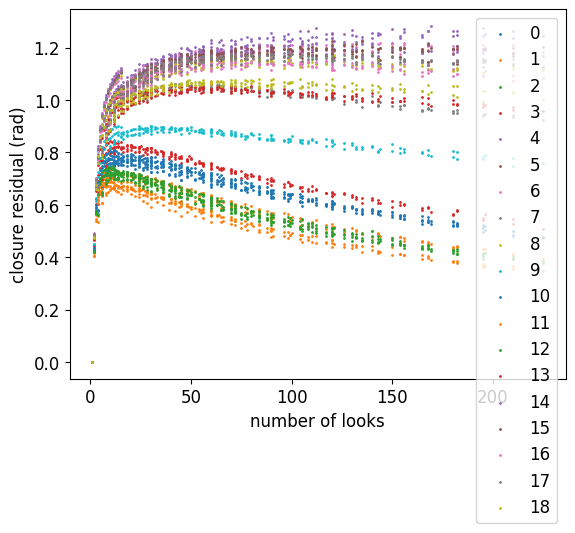

In [ ]:
n_looks = 15
lc = "forest"
m = get_m(lc)
p = Pool()
states = np.empty((m, n_looks, n_looks), dtype=ApplyResult)
for number in range(m):
    for az in range(n_looks):
        for rg in range(n_looks):
            states[number, az, rg] = p.apply_async(compare_looks, args=(az+1, rg+1, number, lc))
p.close()
p.join()
res = np.empty(states.shape)
for i in range(res.shape[0]):
    for j in range(res.shape[1]):
        for k in range(res.shape[2]):
            res[i, j, k] = states[i, j, k].get()
x = np.array([[(i+1)*(j+1) for i in range(n_looks)] for j in range(n_looks)]).ravel()
for i, data in enumerate(res):
    plt.scatter(x, data.ravel(), label=f"{i}", s=1)
plt.legend()
plt.xlabel("number of looks")
plt.ylabel("closure residual (rad)")
plt.show()
# 相干性依次升高的5景: [11, 3, 9, 18, 4]